In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 

from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.optimize import minimize
import scipy.integrate as integrate
from scipy import special
from scipy.special import erf, erfc
from scipy import optimize
from datetime import date
from datetime import datetime
import time 

In [3]:
#load in option data
SPX = pd.read_csv(r"C:\Users\Martin Weirich\OneDrive\Dokumente\MScMathFinance\TopicsInQuantFinance\CBOESPXOptions2019.csv",
                 parse_dates=['date','exdate'],
                  usecols=['date','exdate','cp_flag','strike_price','best_bid','best_bid','best_offer','volume','forward_price'])

In [4]:
#filter option data a little , since the laborde method only uses calls , drop all puts
SPX=SPX[(SPX.best_bid > 0.) & (SPX.date < SPX.exdate)]

SPX.loc[:,'strike_price'] /= 1000.
SPX.loc[:,'cp_flag'] = SPX['cp_flag'].str.lower()
SPX['mid_price'] = (SPX['best_bid'] + SPX['best_offer']) * 0.5
SPX['impl_SPX'] = np.NaN
SPX['impl_fw'] = np.NaN
SPX = SPX[SPX.cp_flag !='p']
SPX.head(10)

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,forward_price,mid_price,impl_SPX,impl_fw
0,2019-01-02,2019-01-18,c,1000.0,1502.8,1508.2,800,2511.210405,1505.50,NaN,NaN
1,2019-01-02,2019-01-18,c,1025.0,1477.8,1483.2,0,2511.210405,1480.50,NaN,NaN
2,2019-01-02,2019-01-18,c,1050.0,1452.9,1458.2,0,2511.210405,1455.55,NaN,NaN
3,2019-01-02,2019-01-18,c,1075.0,1427.9,1433.3,0,2511.210405,1430.60,NaN,NaN
4,2019-01-02,2019-01-18,c,1100.0,1402.9,1408.3,0,2511.210405,1405.60,NaN,NaN
5,2019-01-02,2019-01-18,c,1125.0,1378.0,1383.3,0,2511.210405,1380.65,NaN,NaN
6,2019-01-02,2019-01-18,c,1150.0,1353.0,1358.4,0,2511.210405,1355.70,NaN,NaN
7,2019-01-02,2019-01-18,c,1175.0,1328.0,1333.4,0,2511.210405,1330.70,NaN,NaN
8,2019-01-02,2019-01-18,c,1200.0,1303.1,1308.5,0,2511.210405,1305.80,NaN,NaN
9,2019-01-02,2019-01-18,c,1225.0,1278.1,1283.5,0,2511.210405,1280.80,NaN,NaN


In [5]:
#extract data for one single day
SPX_one_day = SPX[SPX.date == np.datetime64('2019-01-02')]
SPX_one_day

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,forward_price,mid_price,impl_SPX,impl_fw
0,2019-01-02,2019-01-18,c,1000.0,1502.8,1508.2,800,2511.210405,1505.50,NaN,NaN
1,2019-01-02,2019-01-18,c,1025.0,1477.8,1483.2,0,2511.210405,1480.50,NaN,NaN
2,2019-01-02,2019-01-18,c,1050.0,1452.9,1458.2,0,2511.210405,1455.55,NaN,NaN
3,2019-01-02,2019-01-18,c,1075.0,1427.9,1433.3,0,2511.210405,1430.60,NaN,NaN
4,2019-01-02,2019-01-18,c,1100.0,1402.9,1408.3,0,2511.210405,1405.60,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15028,2019-01-02,2019-12-31,c,3000.0,24.2,26.5,0,2544.864708,25.35,NaN,NaN
15029,2019-01-02,2019-12-31,c,3100.0,14.5,16.4,16,2544.864708,15.45,NaN,NaN
15030,2019-01-02,2019-12-31,c,3200.0,8.7,10.2,0,2544.864708,9.45,NaN,NaN
15031,2019-01-02,2019-12-31,c,3300.0,5.3,6.4,0,2544.864708,5.85,NaN,NaN


In [6]:
expiries = list(SPX_one_day.groupby('exdate').groups.keys())
print(expiries)

[Timestamp('2019-01-04 00:00:00'), Timestamp('2019-01-07 00:00:00'), Timestamp('2019-01-09 00:00:00'), Timestamp('2019-01-11 00:00:00'), Timestamp('2019-01-14 00:00:00'), Timestamp('2019-01-16 00:00:00'), Timestamp('2019-01-18 00:00:00'), Timestamp('2019-01-22 00:00:00'), Timestamp('2019-01-23 00:00:00'), Timestamp('2019-01-25 00:00:00'), Timestamp('2019-01-28 00:00:00'), Timestamp('2019-01-30 00:00:00'), Timestamp('2019-01-31 00:00:00'), Timestamp('2019-02-01 00:00:00'), Timestamp('2019-02-04 00:00:00'), Timestamp('2019-02-06 00:00:00'), Timestamp('2019-02-08 00:00:00'), Timestamp('2019-02-15 00:00:00'), Timestamp('2019-02-22 00:00:00'), Timestamp('2019-02-28 00:00:00'), Timestamp('2019-03-15 00:00:00'), Timestamp('2019-03-29 00:00:00'), Timestamp('2019-04-18 00:00:00'), Timestamp('2019-04-30 00:00:00'), Timestamp('2019-05-31 00:00:00'), Timestamp('2019-06-21 00:00:00'), Timestamp('2019-06-28 00:00:00'), Timestamp('2019-09-20 00:00:00'), Timestamp('2019-09-30 00:00:00'), Timestamp('20

In [7]:
tester = SPX_one_day[SPX_one_day.exdate == expiries[0]]
tester = tester[tester.volume !=0]
first_slice = tester.sort_values('strike_price').reset_index(drop = 'True')
delta = first_slice.loc[0,'exdate'] - first_slice.loc[0,'date']
t_1 = delta.days
first_slice

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,forward_price,mid_price,impl_SPX,impl_fw
0,2019-01-02,2019-01-04,c,2000.0,503.90,509.00,7,2510.182809,506.450,NaN,NaN
1,2019-01-02,2019-01-04,c,2220.0,283.90,289.50,1,2510.182809,286.700,NaN,NaN
2,2019-01-02,2019-01-04,c,2225.0,278.90,284.50,1,2510.182809,281.700,NaN,NaN
3,2019-01-02,2019-01-04,c,2240.0,263.90,269.50,1,2510.182809,266.700,NaN,NaN
4,2019-01-02,2019-01-04,c,2250.0,254.50,259.70,3,2510.182809,257.100,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
57,2019-01-02,2019-01-04,c,2615.0,0.05,0.15,714,2510.182809,0.100,NaN,NaN
58,2019-01-02,2019-01-04,c,2620.0,0.05,0.15,1247,2510.182809,0.100,NaN,NaN
59,2019-01-02,2019-01-04,c,2625.0,0.05,0.15,2838,2510.182809,0.100,NaN,NaN
60,2019-01-02,2019-01-04,c,2630.0,0.05,0.10,165,2510.182809,0.075,NaN,NaN


In [8]:
S0 = 2510.03
t0 = date(2019, 1, 2)
first_slice['Strike/Spot'] = first_slice['strike_price']/S0

In [9]:
# Implied volatility calculator
def iv(p,K,T,r,S0):
    """
    Calculate implied volatility using Black-Scholes formula
    
    Parameters:
    p (float): Market price(s) of the option
    K (float): Strike price(s) of the option
    T (float): Time to expiry of the option, in years
    r (float): Risk-free interest rate, as a decimal
    S0 (float): Current price of the underlying asset
    """
    
    d1 = lambda sigma: (np.log(S0/K) + (r + 0.5*(sigma**2))*T) / (sigma*np.sqrt(T))
    d2 = lambda sigma: d1(sigma) - sigma*np.sqrt(T)
    option_price = lambda sigma: S0*norm.cdf(d1(sigma)) - K*np.exp(-r*T)*norm.cdf(d2(sigma))
    option_price_diff = lambda sigma: option_price(sigma) - p
    
    return fsolve(option_price_diff, 0.2*np.ones(len(p)))


In [10]:
# for now take only 20 strikes
first_slice = first_slice.iloc[30:47,:].reset_index(drop = 'True')
first_slice

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,forward_price,mid_price,impl_SPX,impl_fw,Strike/Spot
0,2019-01-02,2019-01-04,c,2480.0,35.90,36.8,136,2510.182809,36.350,NaN,NaN,0.988036
1,2019-01-02,2019-01-04,c,2485.0,32.10,33.1,222,2510.182809,32.600,NaN,NaN,0.990028
2,2019-01-02,2019-01-04,c,2490.0,28.60,29.5,269,2510.182809,29.050,NaN,NaN,0.992020
3,2019-01-02,2019-01-04,c,2495.0,25.20,26.1,1236,2510.182809,25.650,NaN,NaN,0.994012
4,2019-01-02,2019-01-04,c,2500.0,22.00,22.9,4377,2510.182809,22.450,NaN,NaN,0.996004
5,2019-01-02,2019-01-04,c,2505.0,19.00,19.9,480,2510.182809,19.450,NaN,NaN,0.997996
6,2019-01-02,2019-01-04,c,2510.0,16.30,16.9,1022,2510.182809,16.600,NaN,NaN,0.999988
7,2019-01-02,2019-01-04,c,2515.0,13.70,14.3,396,2510.182809,14.000,NaN,NaN,1.001980
8,2019-01-02,2019-01-04,c,2520.0,11.40,11.9,713,2510.182809,11.650,NaN,NaN,1.003972
9,2019-01-02,2019-01-04,c,2525.0,9.40,9.8,3176,2510.182809,9.600,NaN,NaN,1.005964


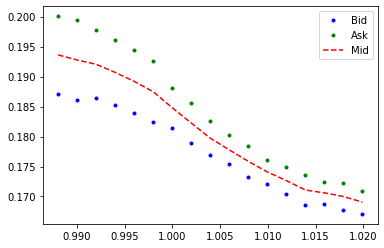

In [11]:
# Gather info for fitting first slice
r = 0.01
C1 = first_slice 
ask = np.array(C1['best_offer'])
bid = np.array(C1['best_bid'])
mid = np.array(C1['mid_price'])
K = np.array(C1['strike_price'])
numK = len(K)
t1 = 2/252


# Plot data
fig, ax = plt.subplots()
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(bid,K,t1,r,S0)), 'b.', label='Bid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(ask,K,t1,r,S0)), 'g.', label='Ask')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(mid,K,t1,r,S0)), 'r--', label='Mid')
plt.legend()
plt.show()

In [12]:
#Pre-compute constants
global SQRT_PI, SQRT2, INV_SQRT2_PI, INV_SQRT2, I_CONST
SQRT2 = np.sqrt(2)
INV_SQRT2 = 1. / SQRT2
SQRT2_PI = np.sqrt(2. * np.pi)
INV_SQRT2_PI = 1. / SQRT2_PI
I_CONST = INV_SQRT2_PI / 2.

615.2286761181031


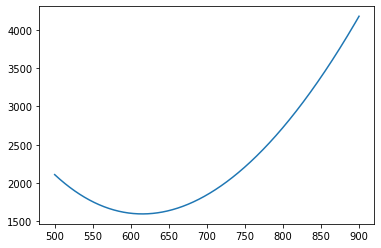

In [13]:
# Objective function for the minimization for sigma_0
def sigma_objective(sigma,S0,delta_t):
    sigma += 1e-100 # to stop divide by zero errors
    sqrtt = math.sqrt(delta_t)
    help_v = (K-S0)/(SQRT2*sqrtt*sigma)
    B_vec = 0.5*(S0-K)*erf(help_v) + sigma*sqrtt*INV_SQRT2_PI*np.exp(-help_v**2)
    return np.sum((B_vec-mid)**2)


def calculate_sigma0(S0,delta_t):
    res = optimize.minimize_scalar(sigma_objective,args = (S0,delta_t))
    return res.x

#visulaise if result makes sense
sigma0 = calculate_sigma0(S0,t1)
xx = np.linspace(500,900,1000)
f = lambda x: sigma_objective(x,S0,t1)
f_ = np.vectorize(f)
plt.plot(xx,f_(xx))
print(sigma0)
P1 = lambda s1: 1

def m0(s2,s1,delta_t,P1):
    '''
    m0: Joint distribution of (s1,s2)
    P1: Marginal distribution of s1
    '''
    #renormalise m_0 on R^+
    sigma0 = calculate_sigma0(s1,delta_t)
    return norm.pdf(s2,s1,sigma0*np.sqrt(delta_t)) / norm.cdf(s1/(sigma0*np.sqrt(delta_t))) * (s1 >= 0)

# define function f from the paper
def f1(V,omega):
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    l = np.zeros(numK)
    
    for i in range(numK):
        if (V[i]*omega[i] <= delta_C_ask[i]) and (V[i]*omega[i] >= delta_C_bid[i]):
            l[i] = V[i]*V[i]*omega[i]/2
        elif V[i]*omega[i] > delta_C_ask[i]:
            l[i] = delta_C_ask[i]*V[i] - delta_C_ask[i]**2/(2*omega[i])
        else: 
            l[i] = delta_C_bid[i]*V[i] - delta_C_bid[i]**2/(2*omega[i])
            
    return l


def grad_f1(V,omega):
    """
    Gradient of g1 with respect to V_K
    """
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    g = np.zeros(numK)
    
    for j in range(numK):
        if (V[j]*omega[j] <= delta_C_ask[j]) and (V[j]*omega[j] >= delta_C_bid[j]):
            g[j] = V[j]*omega[j]
        elif V[j]*omega[j] > delta_C_ask[j]:
            g[j] = delta_C_ask[j]
        else: 
            g[j] = delta_C_bid[j]
    
    return g

In [14]:
#Closed / semi closed form expressions for some useful integrals from remark 4.3 in the paper
def I1(alpha,sigma,s1,K1,K2): 
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return 1/2*np.exp((alpha*sigma)**2/2 + alpha*s1) * (erf((B-alpha*sigma)*INV_SQRT2) - erf((A-alpha*sigma)*INV_SQRT2) )
    
def I2(alpha,sigma,s1,K1,K2):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return sigma*np.exp(alpha*s1) * ( 2*(np.exp(A*alpha*sigma-A*A/2) - np.exp(B*alpha*sigma-B*B/2)) + SQRT2_PI*alpha*sigma*np.exp(alpha*sigma*alpha*sigma/2)*(erf((B-alpha*sigma)*INV_SQRT2) - erf((A-alpha*sigma)*INV_SQRT2)) )
    
def I3(alpha,sigma,s1,K1,K2,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return np.exp(alpha*s1) *  (2*sigma*(np.exp(A*alpha*sigma-A**2/2) - np.exp(B*alpha*sigma-B**2/2)) + SQRT2_PI*np.exp(alpha*alpha*sigma*sigma/2)*(alpha*sigma**2-Q+s1) * (erf((B-alpha*sigma)*INV_SQRT2) - erf((A-alpha*sigma)*INV_SQRT2)) )

def I4(alpha,sigma,s1,K1,K2,K,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma  
    return 2*sigma* (np.exp(alpha*A*sigma-A*A/2)*(sigma*(alpha*sigma+A) - K - Q + 2*s1) + np.exp(-1/2*B*(B-2*alpha*sigma))*(-sigma*(alpha*sigma+B) + K + Q -2*s1)) + SQRT2_PI*np.exp(alpha*sigma*alpha*sigma/2)*(erf((B-alpha*sigma)/(np.sqrt(2))) - erf((A-alpha*sigma)*INV_SQRT2) ) * (sigma**2 - (-alpha*sigma**2+K-s1)*(alpha*sigma**2-Q+s1))

In [15]:
#Calculate I_u via numerical integration to later check the closed form
def I_u_integrand(s,theta,V,K,s1,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))-theta*(s-s1))*m0(s,s1,delta_t,P1)

def I_u(theta,V,K,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_u_integrand,K1,K2,args=(theta,V,K,s1,delta_t,P1) )[0]

def I_u_(theta,V,K,s1,K1,K2,delta_t,P1):
    sigma0 = calculate_sigma0(s1,delta_t)
    sigma = sigma0*np.sqrt(delta_t)
    totI = 0

    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) - theta
        gamma = sum(V[:i+1]*K[:i+1]) + (theta*s1)

        if i == -1: 
            newPiece = np.exp(gamma) * I1(alpha,sigma,s1,K1,K[0])
        elif i >= 0 and i < numK-1:
            newPiece = np.exp(gamma) * I1(alpha,sigma,s1,K[i],K[i+1])
        else:
            newPiece = np.exp(gamma) * I1(alpha,sigma,s1,K[-1],K2)
        
        totI += newPiece
    
    return totI

In [16]:

def I_h_0_integrand(s,theta,V,K,s1,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))-theta*(s-s1))*m0(s,s1,delta_t,P1)*(s-s1)

def I_h_0(theta,V,K,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_h_0_integrand,K1,K2,args=(theta,V,K,s1,delta_t,P1))[0]

def I_h_0_(theta,V,K,s1,K1,K2,sigma0,delta_t,P1):
    sigma = sigma0*np.sqrt(delta_t)
    totI = 0
    
    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) - theta
        gamma = sum(V[:i+1]*K[:i+1]) + (theta*S0)
        
        if i == -1: 
            newPiece = np.exp(gamma) * I_CONST * I2(alpha,sigma,s1,K1,K[0])
        elif i >= 0 and i < numK-1:
            newPiece = np.exp(gamma) * I_CONST * I2(alpha,sigma,s1,K[i],K[i+1])
        else:
            newPiece = np.exp(gamma) * I_CONST * I2(alpha,sigma,s1,K[-1],K2)
        
        totI += newPiece
    
    return totI

def I_h_0_grad_integrand(s,theta,V,K,s1,delta_t,P1):
    return -np.exp(-np.sum(V*np.maximum(s-K,0))-theta*(s-S0))*m0(s,s1,delta_t,P1)*(s-s1)**2
    
def I_h_0_grad(theta,V,K,s1,K1,K2,sigma0,delta_t,P1):
    return integrate.quad(I_h_0_grad_integrand,K1,K2,args=(theta,V,K,s1,delta_t,P1))[0]


def I_h_0_hessian_integrand(s,theta,V,K,s1,sigma0,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))-theta*(s-s1))*m0(s,s1,delta_t,P1)*(s-s1)**3

def I_h_0_hessian(theta,V,K,s1,K1,K2,sigma0,delta_t,P1):
    return integrate.quad(I_h_0_hessian_integrand,K1,K2,args=(theta,V,K,s1,sigma0,delta_t,P1))[0]

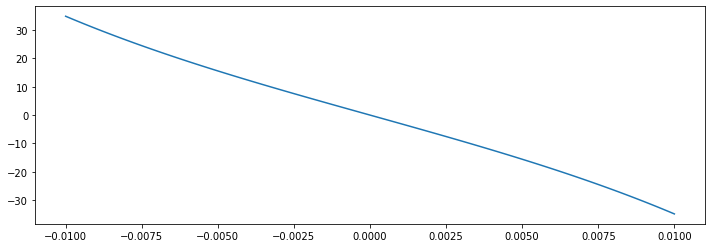

In [17]:
# Find proper bounds for h root finding

u1, h1, V = 0., 0., np.array([0.]*numK)
V_prev = np.array([1] *numK)
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)
delta_t = t1
P1 = lambda s1: 1

xx = np.linspace(-0.01,0.01,100)
yy = []
for x in xx:
    yy.append(I_h_0_(x,V,K,S0,2510-300,2510+300,sigma0,t1,P1))
    
plt.figure(figsize=(12,4))
plt.plot(xx,yy)

In [18]:
def I_Q_integrand(s,h0,V,K,Q,s1,delta_t,P1):
    return math.exp(-np.sum(V*np.maximum(s-K,0))-h0*(s-S0))*m0(s,s1,delta_t,P1)*np.maximum(s-Q,0)

def I_Q(h0,V,K,Q,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_Q_integrand,K1,K2,args=(h0,V,K,Q,s1,delta_t,P1))[0]

I_Q_CONST = 1/(2*np.sqrt(2*math.pi))
def I_Q_(h0,V,K,Q,s1,K1,K2,delta_t,P1):
    sigma0 = calculate_sigma0(s1,delta_t)
    sigma = sigma0*np.sqrt(delta_t)
    Q = np.array(Q)
    if (Q.shape == ()):
      totI = np.zeros(1)
    else:
      totI = np.zeros(Q.shape)

    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) - h0 
        gamma = sum(V[:i+1]*K[:i+1]) + h0*S0
        
        if i == -1: 
            newPiece = np.exp(gamma) * I_Q_CONST * I3(alpha,sigma,s1,Q,K[0],Q) * (K[0] >= Q)
        elif i >= 0 and i < numK-1:
            newPiece = np.exp(gamma) * I_Q_CONST * I3(alpha,sigma,s1,np.maximum(Q,K[i]),K[i+1],Q) * (K[i+1] >= Q)
        else:
            newPiece = np.exp(gamma) * I_Q_CONST * I3(alpha,sigma,s1,np.maximum(Q,K[-1]),K2,Q)
            
        totI += newPiece

    return totI

In [19]:
def integrand_G1(s,V,u0,h0,K,omega,S0,delta_t,P1):
    return m0(s,S0,delta_t,P1)*np.exp(-np.sum(V*np.maximum(s-K,0))-(u0+h0*(s-S0)))
    

def G1(V,u0,h0,K,omega,S0,delta_t,P1):
    expectation = I_u_(h0,V,K,S0,S0-400, S0+400,delta_t,P1)*np.exp(-u0)
    return u0 + np.sum(V*mid) + np.sum(f1(V,omega)) + expectation

    
def grad_G1(V,u0,h0,K,omega,S0,delta_t,P1):
    """
    Gradient of G_12 with respect to V_K_i
    """
    gf1 = grad_f1(V,omega)
    grad = np.zeros(numK)
    grad = gf1 + mid - I_Q_(h0,V,K,K,S0,S0-400,S0+400,delta_t,P1)*np.exp(-u0) # second K is Q in notation
    
    return grad

In [20]:
u1, h1, V = 0., 0., np.array([0.]*numK)
V_prev = np.array([1] *numK)
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)
delta_t = t1
P1 = lambda s1: 1
sigma0 = calculate_sigma0(S0,delta_t)

start = time.time()
while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:
    V_prev = V
    #projection on h and u
    h0 = optimize.root_scalar(I_h_0_,args=(V,K,S0,S0-300, S0+300,sigma0,delta_t,P1) ,bracket = [-0.05,0.05],x0=0.00005, fprime = I_h_0_grad, fprime2 = I_h_0_hessian).root
    u0 = np.log(I_u_(h0,V,K,S0,S0-300, S0+300,delta_t,P1))

    #optimisation of G over V using quasi Newton
    V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,delta_t,P1), method='TNC', jac= grad_G1, hess=None, hessp=None, bounds=None, constraints=(), tol=1e-5, callback=None, options=None).x

end = time.time()
print("elapsed time = ",end-start)

C:\Users\lachl\AppData\Local\Temp/ipykernel_25120/1415616913.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:


elapsed time =  4.6267173290252686


In [21]:
# Calculate call prices
n = numK*50
xx = np.linspace(2465, 2560, n, endpoint = True)
c = I_Q_(h0,V,K,xx,S0,S0-300,S0+300,delta_t,P1)*np.exp(-u0)

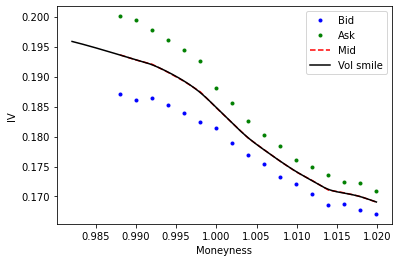

In [22]:
# Plot data
fig, ax = plt.subplots()
T_ = t1
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(bid,K,T_,r,S0)), 'b.', label='Bid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(ask,K,T_,r,S0)), 'g.', label='Ask')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(mid,K,T_,r,S0)), 'r--', label='Mid')
v = np.zeros(n)
for i in range(n):
    v[i] = iv(np.array([c[i]]), np.array([xx[i]]), T_, r, S0)
ax.plot(xx / S0, v, 'k', label='Vol smile')
ax.set_ylabel('IV')
ax.set_xlabel('Moneyness')
plt.legend()
plt.show()

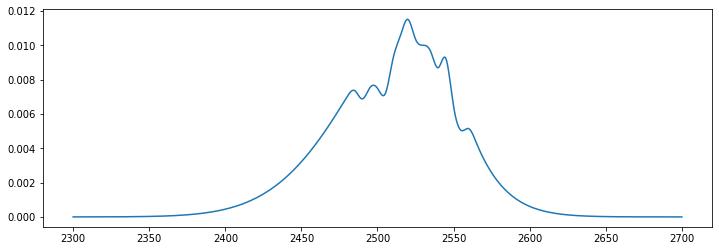

In [24]:
#Plot marginal pdf:
xx = np.linspace(2300,2700,500)
for x in xx:
    c = I_Q_(h0,V,K,xx,S0,S0-300,S0+300,delta_t,P1)*np.exp(-u0)
    c_p = I_Q_(h0,V,K,xx+5,S0,S0-300,S0+300,delta_t,P1)*np.exp(-u0)
    c_m =  I_Q_(h0,V,K,xx-5,S0,S0-300,S0+300,delta_t,P1)*np.exp(-u0)
    f_x = (c_p-2*c+c_m)/(25)

plt.figure(figsize=(12,4))
plt.plot(xx,f_x)
plt.show()